In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import pickle
import lightgbm as lgb

from tqdm import tqdm_notebook


import time
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import librosa  # MFCC feature
from multiprocessing import Pool

%matplotlib inline
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'data_loader'

In [50]:
def feature_sta_lta_ratio(x, length_sta, length_lta):
    """ short-term change over long-term change ratio (not rolling mean)"""
    x = np.cumsum(x ** 2)
    # Convert to float
    x = np.require(x, dtype=np.float)

    sta = x
    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [15]:
df = pickle.load(open('./data/train.p', 'rb'))

In [22]:
x[length_sta:]

array([-12,   0,  -3, ...,  -1,  -4, -10], dtype=int16)

In [52]:
x = df.iloc[:150_000]['acoustic_data'].values
length_sta = 500
length_lta = 10000
np.mean(feature_sta_lta_ratio(x, length_sta, length_lta))
# x = np.require(x, dtype=np.float)
# x = np.cumsum(x ** 2)


0.9418946516536265

In [28]:
x

array([12.,  6.,  8., ...,  1., 11., -2.])

In [49]:
np.mean(sta / lta)

0.9386300179555921

In [46]:
np.min(lta), np.max(lta), np.min(sta), np.max(sta)

(0.0144, 3239.2101, 0.0, 2868.516)

In [45]:
sta = x
# Copy for LTA
lta = sta.copy()

# Compute the STA and the LTA
sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
sta /= length_sta
lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
lta /= length_lta

# Pad zeros
sta[:length_lta - 1] = 0

# Avoid division by zero by setting zero values to tiny float
dtiny = np.finfo(0.0).tiny
idx = lta < dtiny
lta[idx] = dtiny

In [2]:
# train = pd.read_cv('./train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
X_tr, y_tr = pickle.load(open('./data/transform.p', 'rb'))
# X_tr['var_larger_than_std_dev'] = X_tr['var_larger_than_std_dev'].astype(bool)
# tmp = X_tr, y_tr
# pickle.dump(tmp, open('./data/transform.p', 'wb'))

In [11]:
X_tr['classic_sta_lta2_mean']

0      -3.780659e+300
1      -6.460025e+300
2      -3.424898e+301
3      -3.028319e+301
4      -3.459334e+301
5      -1.243499e+301
6      -1.107918e+301
7      -2.442249e+301
8      -1.539973e+301
9      -9.946856e+300
10     -6.436856e+300
11     -1.037211e+301
12     -4.691819e+301
13     -8.947050e+300
14     -2.855275e+301
15     -3.765478e+301
16     -2.137984e+301
17     -1.753078e+301
18     -6.134418e+300
19     -1.519719e+301
20     -1.581193e+301
21     -1.037000e+301
22     -2.893076e+301
23     -1.813650e+301
24     -1.063641e+301
25     -2.252058e+301
26     -1.428075e+301
27     -1.578891e+301
28     -1.903928e+301
29     -1.650891e+302
            ...      
4165   -2.413613e+300
4166   -1.081887e+300
4167   -2.098123e+300
4168   -2.255038e+301
4169   -1.743056e+300
4170   -7.174243e+300
4171   -3.186410e+300
4172   -5.983741e+300
4173   -2.006504e+300
4174   -2.641130e+300
4175   -1.746073e+300
4176   -1.875242e+300
4177   -1.192012e+301
4178   -8.414769e+300
4179   -1.

In [10]:
X_tr['classic_sta_lta1_mean']

0                -inf
1                 NaN
2                 NaN
3                -inf
4                -inf
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
10               -inf
11                NaN
12                NaN
13                NaN
14                NaN
15               -inf
16               -inf
17                NaN
18                NaN
19               -inf
20                NaN
21               -inf
22               -inf
23                NaN
24                NaN
25                NaN
26                NaN
27               -inf
28               -inf
29               -inf
            ...      
4165             -inf
4166             -inf
4167             -inf
4168             -inf
4169             -inf
4170             -inf
4171             -inf
4172             -inf
4173             -inf
4174             -inf
4175             -inf
4176             -inf
4177             -inf
4178             -inf
4179      

In [9]:
X_tr[X_tr['classic_sta_lta1_mean'].isnull()]

,kstat_1,kstat_2,kstat_3,kstat_4,abs_energy,abs_sum_of_changes,count_above_mean,count_below_mean,range_minf_m4000,range_m4000_m3000,...,std_abs_roll_mean_1000,skew_abs_roll_mean_1000,kurt_abs_roll_mean_1000,trend_abs_roll_mean_1000,av_change_abs_roll_mean_1000,std_abs_roll_std_1000,skew_abs_roll_std_1000,kurt_abs_roll_std_1000,trend_abs_roll_std_1000,av_change_abs_roll_std_1000
1,4.725767,43.412599,111.715131,1.861256e+05,9.861777e+06,405226.0,78895.0,71105.0,0.0,0.0,...,0.231587,-0.037062,-0.401379,9.653721e-07,-2.449664e-06,4.492905,4.929236,28.679984,-1.121682e-05,-2.309726e-07
2,4.906393,48.544621,73.527934,7.907555e+04,1.089255e+07,418888.0,81264.0,68736.0,0.0,0.0,...,0.267012,-0.151764,0.024981,4.012455e-06,1.140940e-06,4.402140,3.022971,11.461228,1.334542e-05,2.461592e-06
5,4.913513,29.529564,-16.158473,4.378736e+04,8.050797e+06,397547.0,82083.0,67917.0,0.0,0.0,...,0.293941,0.017696,-0.290736,-3.784425e-06,-3.697987e-06,2.988882,3.526528,15.983611,4.966489e-06,-1.532087e-05
6,4.855660,32.351335,38.422837,2.425307e+04,8.389283e+06,405963.0,80767.0,69233.0,0.0,0.0,...,0.219472,-0.125773,0.139323,-1.205116e-06,-1.140940e-07,3.076797,2.507709,7.062755,1.303930e-06,-9.768944e-06
7,4.505427,34.275306,-35.383889,6.154611e+04,8.186092e+06,397772.0,75239.0,74761.0,0.0,0.0,...,0.218514,-0.034279,-0.591635,-1.083021e-06,-1.395973e-06,3.763099,3.624339,13.900135,2.010945e-06,-3.531460e-07
8,4.717833,60.678540,-75.704774,2.406490e+05,1.244041e+07,426464.0,78149.0,71851.0,0.0,0.0,...,0.240917,0.051240,0.073161,1.361871e-06,2.221477e-06,5.328289,3.943054,18.781140,-1.136465e-05,-5.309154e-05
9,4.730960,47.478427,49.327073,1.211863e+05,1.047901e+07,413719.0,78532.0,71468.0,0.0,0.0,...,0.258462,-0.127301,-0.698977,3.306325e-06,5.127517e-06,4.536889,4.217263,24.512240,-1.383861e-05,-7.395172e-07
11,4.329933,232.684522,-2463.618618,1.493312e+06,3.771469e+07,469850.0,72526.0,77474.0,0.0,0.0,...,0.264041,-0.712626,3.661999,2.001403e-06,-2.510067e-06,13.273192,6.369808,45.607258,-7.241738e-05,-3.197393e-05
12,4.464040,75.004287,-102.253440,3.214191e+05,1.423972e+07,430396.0,74083.0,75917.0,0.0,0.0,...,0.264723,-0.105624,0.525059,2.294254e-06,2.167785e-06,6.269596,3.848390,17.006576,9.597697e-06,-2.082303e-06
13,4.680813,36.401269,39.939658,5.625247e+04,8.746656e+06,403675.0,77828.0,72172.0,0.0,0.0,...,0.277478,0.377165,0.019861,2.929599e-06,4.362416e-06,3.557925,3.513316,15.373885,-4.116544e-06,-2.827560e-06


In [11]:
X_tr['num_peaks_500'].head()

0    93.0
1    77.0
2    82.0
3    83.0
4    79.0
Name: num_peaks_500, dtype: float64

In [10]:
X_tr, y_tr = pickle.load(open('./data/transform (another copy).p', 'rb'))
X_tr['num_peaks_500'].head()

0    93.0
1    77.0
2    82.0
3    83.0
4    79.0
Name: num_peaks_500, dtype: float64

In [19]:
a = pickle.load(open('./data/earthquake_id.p', 'rb'))
a[4194] = 16
pickle.dump(a, open('./data/earthquake_id.p', 'wb'))

In [18]:
a.shape

(4195,)

In [22]:
X_test = pickle.load(open('./data/test_transform.p', 'rb'))
X_test = X_test.astype('float')
X_test['var_larger_than_std_dev'] = X_test['var_larger_than_std_dev'].astype(bool)
pickle.dump(X_test, open('./data/test_transform.p', 'wb'))

In [8]:
X_test.shape

(2624, 134)

In [3]:
X_tr.columns[X_tr.isnull().any()]

Index(['classic_sta_lta1_mean', 'classic_sta_lta1_std',
       'classic_sta_lta2_mean', 'classic_sta_lta2_std'],
      dtype='object')

In [31]:
X_tr['var_larger_than_std_dev'].unique()

array([ True])

In [11]:
X_tr.describe().to_csv('./view.csv')

In [19]:
a, _ = data_transform.missing_fix_tr(X_tr)

classic_sta_lta1_mean
classic_sta_lta1_std
classic_sta_lta2_mean


In [20]:
a.columns[a.isnull().any()]

Index(['classic_sta_lta1_mean', 'classic_sta_lta1_std',
       'classic_sta_lta2_mean'],
      dtype='object')

In [35]:
mfcc = librosa.feature.mfcc(X_tr['mean'].values)

In [39]:
for i in mfcc:
    print(i)
    break

[44.16311128 49.4843467  50.61085947 50.35735602 48.53195817 47.57174239
 48.4750341  52.46645971 50.36675035]


In [37]:
librosa.feature.delta(mfcc).mean(axis=1)

array([ 0.44506052, -0.06323289, -0.12178521,  0.39719124,  0.49571561,
        0.03873742, -0.34894707, -1.19010039,  0.12544813,  0.8258489 ,
        0.44304384,  0.29726732,  0.87128261, -0.42895611, -1.66516048,
       -0.0220214 ,  0.27425114, -0.41384509,  0.30193733,  0.78675206])

In [11]:
import collections 
  
# initializing dictionaries 
dic1 = { 'a' : 1, 'b' : 2 } 
dic2 = { 'b' : 3, 'c' : 4 } 
  
# initializing ChainMap 
chain = collections.ChainMap(dic1, dic2)

In [20]:
df2 = pd.read_csv(r'./submission1.csv')
df2.head()

,seg_id,time_to_failure
0,seg_ea9d37,8.090795
1,seg_211486,8.106824
2,seg_bdae02,8.108381
3,seg_23f823,8.090795
4,seg_72b68c,8.108381


In [27]:
df1 = pd.read_csv(r'./source/submission.csv')
# df1['seg_id'] = df2['seg_id']
# df1.to_csv(r'./source/submission.csv', index=False)
df1.head()

,seg_id,time_to_failure
0,seg_ea9d37,1.430730
1,seg_211486,1.393251
2,seg_bdae02,1.353633
3,seg_23f823,1.314905
4,seg_72b68c,1.275586


In [28]:
df2['time_to_failure'] = df1['time_to_failure']
df2.to_csv(r'./source/submission.csv', index=False)

In [29]:
df2.head()

,seg_id,time_to_failure
0,seg_ea9d37,1.430730
1,seg_211486,1.393251
2,seg_bdae02,1.353633
3,seg_23f823,1.314905
4,seg_72b68c,1.275586


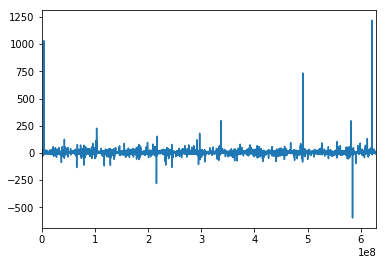

In [17]:
tmp = train['acoustic_data'][::15000]
train['acoustic_data'][::15000].plot()

In [19]:
np.cumsum(tmp ** 2) / np.cumsum(tmp ** 2).shift()

0                 NaN
15000        1.173611
30000        1.378698
45000        1.017167
60000        1.016878
75000        1.203320
90000        1.000000
105000       1.124138
120000       1.049080
135000       1.187135
150000       1.061576
165000       1.187935
180000       1.095703
195000       1.016043
210000       1.449123
225000       1.030266
240000       1.042303
255000       1.112740
270000       1.036474
285000       1.047898
300000       1.023321
315000       1.022789
330000       1.014260
345000       1.014060
360000       1.007799
375000       1.007739
390000       1.054608
405000       1.020227
420000       1.028549
435000       1.006939
               ...   
628710000    1.000000
628725000    1.000009
628740000    1.000003
628755000    1.000009
628770000    1.000009
628785000    1.000018
628800000    1.000030
628815000    1.000000
628830000    1.000009
628845000    1.000003
628860000    1.000006
628875000    1.000030
628890000    1.000000
628905000    1.000038
628920000 

In [5]:
train.isnull().any()

acoustic_data      False
time_to_failure    False
dtype: bool

In [3]:
# import pickle
# pickle.dump(train, open('./train.p', 'wb'))

In [4]:
# detect points corresponding to quake occurrence
quake_list = np.where(np.diff(train['time_to_failure']) > 5)[0]
len(quake_list)

## Feature Engineering

General idea: downsample, summarize every period to useful statistics

In [6]:
# Create a training file with simple derived features

# test sample length
rows = 150_000

segments = int(np.floor(train.shape[0] / rows))

In [7]:
X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [8]:
for seg_i in range(segments):
    seg = train.iloc[seg_i * rows : (seg_i + 1) * rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[seg_i, 'time_to_failure'] = y

    # Usual aggregations: mean, std, min and max
    X_tr.loc[seg_i, 'mean'] = x.mean()
    X_tr.loc[seg_i, 'std'] = x.std()
    X_tr.loc[seg_i, 'max'] = x.max()
    X_tr.loc[seg_i, 'min'] = x.min()
    X_tr.loc[seg_i, 'mad'] = x.mad()
    X_tr.loc[seg_i, 'kurt'] = x.kurtosis()
    X_tr.loc[seg_i, 'skew'] = x.skew()
    X_tr.loc[seg_i, 'med'] = x.median()
    
    # abs
    X_tr.loc[seg_i, 'abs_min'] = np.abs(x.min())
    X_tr.loc[seg_i, 'abs_max'] = np.abs(x.max())
    X_tr.loc[seg_i, 'abs_std'] = np.abs(x).std()
    

    # quantile related
    for q in (0.1, 0.3, 0.7, 0.9):
        X_tr.loc[seg_i, f'q{q}'] = np.quantile(x, q)
        
    

In [18]:
# leaveOneGroupMaker()
failure_time_tr = (np.array(quake_list) / rows).astype(int).tolist()
import copy
def yield_group(num_fold):
    prev = 0
    dump = []
    for cur in failure_time_tr:
        dump.append(list(range(prev, cur)))
        prev = cur
    dump.append(range(cur, len(X_tr) - 1))
    total_num = len(dump)
    for i in range(num_fold):
        valid_index = []
        train_index = copy.deepcopy(dump)
        to_remove = set()
        for j in range(total_num):
            if ((j + i) % num_fold) == 0:
                valid_index.append(train_index[j])
                to_remove.add(j)
        train_index = [group for i, group in enumerate(train_index) 
                       if i not in to_remove]
    
        train_index = [i for item in train_index for i in item]
        valid_index = [i for item in valid_index for i in item]

        yield train_index, valid_index

In [19]:
n_fold = 5
# folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [20]:
# Test run
X = X_tr
# scaler = StandardScaler()
# scaler.fit(X)
# X = pd.DataFrame(scaler.transform(X), columns=X.columns)

y = y_tr



scores = []
# for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
for fold_n, (train_index, valid_index) in enumerate(yield_group(n_fold)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = n_fold)
        model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
        y_pred_valid = model.predict(X_valid)
#         y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

Fold 0 started at Fri Apr  5 22:30:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[590]	training's l1: 2.13757	valid_1's l1: 1.8705
Fold 1 started at Fri Apr  5 22:30:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[720]	training's l1: 1.87969	valid_1's l1: 2.55085
Fold 2 started at Fri Apr  5 22:30:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[370]	training's l1: 2.29026	valid_1's l1: 1.95741
Fold 3 started at Fri Apr  5 22:30:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[870]	training's l1: 1.67935	valid_1's l1: 3.02499
Fold 4 started at Fri Apr  5 22:30:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2080]	training's l1: 1.83032	valid_1's l1: 1.84556
CV mean score: 2.2499, std: 0.4657.


In [21]:
from source.data_transform import transform

In [27]:
a =pd.DataFrame(transform(X_valid['mean']), index=[0])

In [45]:
model.predict(a)[0]

8.25973207374091

In [29]:
x

,mean,std,max,min,mad,kurt,skew,med,abs_min,abs_max,abs_std,q0.1,q0.3,q0.7,q0.9
0,4.515945,0.225901,5.131573,3.79802,0.181811,-0.17525,-0.005196,4.515593,3.79802,5.131573,0.225901,4.226035,4.39222,4.642872,4.788357


In [30]:
X_valid.columns

Index(['mean', 'std', 'max', 'min', 'mad', 'kurt', 'skew', 'med', 'abs_min',
       'abs_max', 'abs_std', 'q0.1', 'q0.3', 'q0.7', 'q0.9'],
      dtype='object')

In [47]:
import os
result = {}
for r, d, f in os.walk('./test'):
    for file in f:
        if file.endswith('.csv'):
            name = file.split('.', 1)[0]
            df = pd.read_csv(os.path.join('./test', file), dtype={'acoustic_data': np.int16})
            x = transform(df)
            x =pd.DataFrame(x, index=[0])
            y = model.predict(x)[0]
            result[name] = y                                               

In [51]:
df = pd.Series(result).to_frame()

In [58]:
df.index.name = 'seg_id'
df = df.rename(columns={0: 'time_to_failure'})
df.to_csv('./submission.csv')

In [6]:
df = pd.read_csv('./data/test/seg_0a0fbb.csv', dtype={'acoustic_data': np.int16})

In [10]:
df.dtypes

acoustic_data    int16
dtype: object

In [14]:
df['acoustic_data']

0          3
1         -3
2         -1
3          6
4          8
5          1
6          6
7          5
8          6
9          8
10         5
11         2
12        10
13        13
14         3
15         1
16         0
17         3
18         2
19         5
20         5
21         6
22         7
23        10
24         6
25         5
26         7
27         5
28         3
29         6
          ..
149970     4
149971     5
149972     7
149973     2
149974     0
149975     4
149976     5
149977     3
149978     8
149979     6
149980     6
149981     5
149982     7
149983     3
149984     1
149985     1
149986     2
149987     4
149988     7
149989     3
149990     0
149991     2
149992     5
149993     2
149994     4
149995     8
149996     4
149997     1
149998     3
149999     2
Name: acoustic_data, Length: 150000, dtype: int16

In [3]:
output1 = {'a': 1, 'b': 2}
output2 = {'a': 3, 'b': 4}
d = {'cc': output1, 'dd': output2}
pd.DataFrame(d).T

,a,b
cc,1,2
dd,3,4


In [5]:
df = pickle.load(open('./data/test_transform.p', 'rb'))

In [6]:
df.head()

,MA_1000MA_std_mean,MA_400MA_BB_high_mean,MA_400MA_BB_low_mean,MA_700MA_BB_high_mean,MA_700MA_BB_low_mean,abs_max,abs_max_roll_mean_10,abs_max_roll_mean_100,abs_max_roll_mean_1000,abs_max_roll_std_10,...,std_first_10000,std_first_50000,std_last_10000,std_last_50000,std_roll_mean_10,std_roll_mean_100,std_roll_mean_1000,std_roll_std_10,std_roll_std_100,std_roll_std_1000
seg_ea9d37,4.568766,17.530626,-8.821744,17.826056,-9.117174,122.0,71.3,8.80,5.210,80.120465,...,3.975093,5.173851,8.106770,5.518180,3.042239,0.437763,0.240919,3.092674,3.431853,2.998720
seg_211486,3.322039,13.781149,-5.715271,13.895094,-5.829216,78.0,49.4,7.68,4.622,57.760425,...,3.289709,3.225403,4.696127,4.802056,1.948658,0.381269,0.226287,1.991232,2.169874,1.976430
seg_bdae02,3.144050,13.137599,-5.388415,13.228319,-5.479135,66.0,56.3,7.32,4.562,51.145109,...,2.702924,2.954444,2.713655,4.076679,1.671995,0.368735,0.224855,1.651704,1.731129,1.547032
seg_23f823,5.107213,18.656420,-10.386189,19.091849,-10.821618,126.0,75.2,10.49,5.027,93.115281,...,3.961759,4.514219,10.785993,8.251113,3.745786,0.495398,0.286305,4.195660,4.740190,4.243137
seg_72b68c,3.202152,13.340650,-5.495507,13.440527,-5.595385,61.0,32.5,6.28,4.655,46.182729,...,3.066599,3.971962,3.179485,3.079516,1.636616,0.383549,0.245224,1.834307,1.843239,1.641587


In [16]:
!cd source

In [19]:
!l

/bin/sh: 1: l: not found


In [14]:
import source.data_loader

ModuleNotFoundError: No module named 'data_transform'